In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the csv file

In [2]:
file = 'sentiments.csv' 
df = pd.read_csv(file, encoding='ISO-8859-1', names = ['target','ids','date','flag','user','tweet'])
df.head()

,target,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweet   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.duplicated().sum()

np.int64(0)

<h3> There are no duplicates in the dataset

In [5]:
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
tweet     0
dtype: int64

<h3> There are no null values in the dataset

In [6]:
#preprocessing the tweet text for better analysis: Removing unnecessary parts of each tweet, punctuations and converting to lowercase
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower() 

In [7]:
df['tweet'] = df['tweet'].apply(clean_tweet)

In [8]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

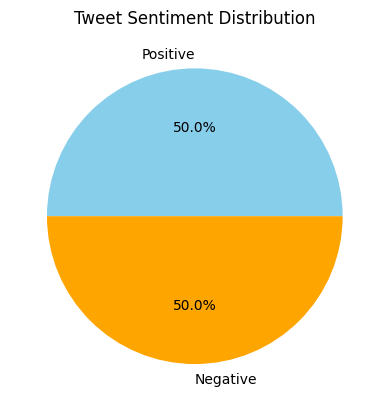

In [9]:
df['target'].value_counts().plot(
    kind='pie',
    labels=['Positive', 'Negative'] if df['target'].nunique() == 2 else ['Negative', 'Neutral', 'Positive'],
    autopct='%1.1f%%',
    colors=['skyblue', 'orange', 'red'],
    title='Tweet Sentiment Distribution',
    ylabel='')
plt.show()

<h3> Pie chart indicate that there is no class imbalance

In [10]:
#Removing the columns that are not required for the analysis:
df = df[['tweet', 'target']]
df.head()

,tweet,target
0,a thats a bummer you shoulda got david carr of...,0
1,is upset that he cant update his facebook by t...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no its not behaving at all im mad why am i her...,0


# Label Mapping

In [11]:
label_map_string = {0: 'Negative', 2: 'Neutral', 4: 'Positive'}
df['sentiment_string'] = df['target'].map(label_map_string)
df

,tweet,target,sentiment_string
0,a thats a bummer you shoulda got david carr of...,0,Negative
1,is upset that he cant update his facebook by t...,0,Negative
2,i dived many times for the ball managed to sav...,0,Negative
3,my whole body feels itchy and like its on fire,0,Negative
4,no its not behaving at all im mad why am i her...,0,Negative
...,...,...,...
1599995,just woke up having no school is the best feel...,4,Positive
1599996,thewdbcom very cool to hear old walt interview...,4,Positive
1599997,are you ready for your mojo makeover ask me fo...,4,Positive
1599998,happy th birthday to my boo of alll time tupac...,4,Positive


In [12]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# Train-test split

In [13]:
X = df['tweet']
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Feature Extraction

In [14]:
#Since we are dealing with text data, we need to vectorize it into numerical data using TFIDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# Model Building and evaluation metrics

C:\Users\reddy\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:58:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.760


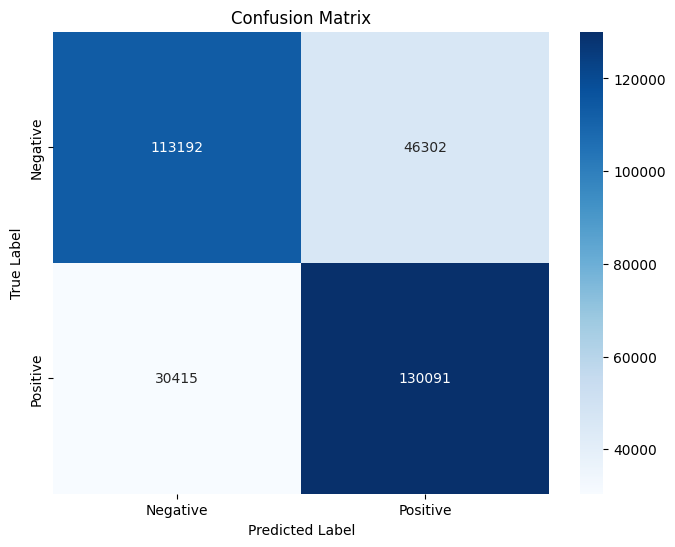


Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.71      0.75    159494
    Positive       0.74      0.81      0.77    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



In [16]:

model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))